In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ERA_V2/Assignment21_unet/

/content/drive/MyDrive/ERA_V2/Assignment21_unet


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import imageio
from PIL import Image


In [4]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

In [5]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

<ipython-input-9-1e9bed434f54>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-9-1e9bed434f54>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


(414, 455, 3)
(414, 455)


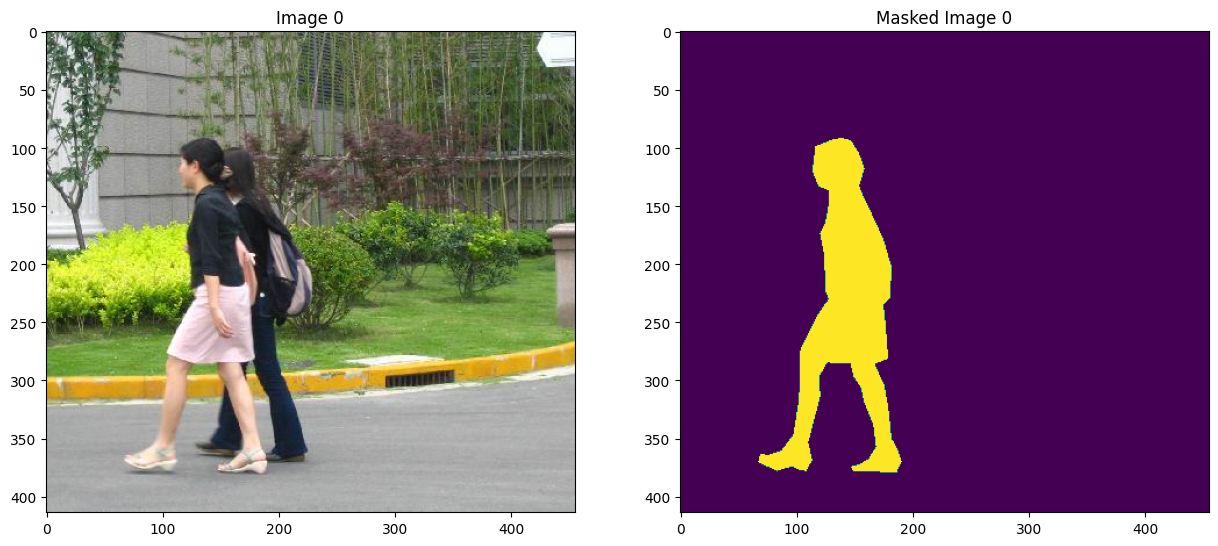

In [9]:
path1 = '/content/drive/MyDrive/ERA_V2/Assignment21_unet/data/train_images/'
path2 = '/content/drive/MyDrive/ERA_V2/Assignment21_unet/data/train_masks/'

img, mask = LoadData (path1, path2)

show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (146, 128, 128, 3)
Y shape: (146, 128, 128, 1)
[  0   1   2   3   4   5   6   7   8 255]


Text(0.5, 1.0, 'Processed Masked Image ')

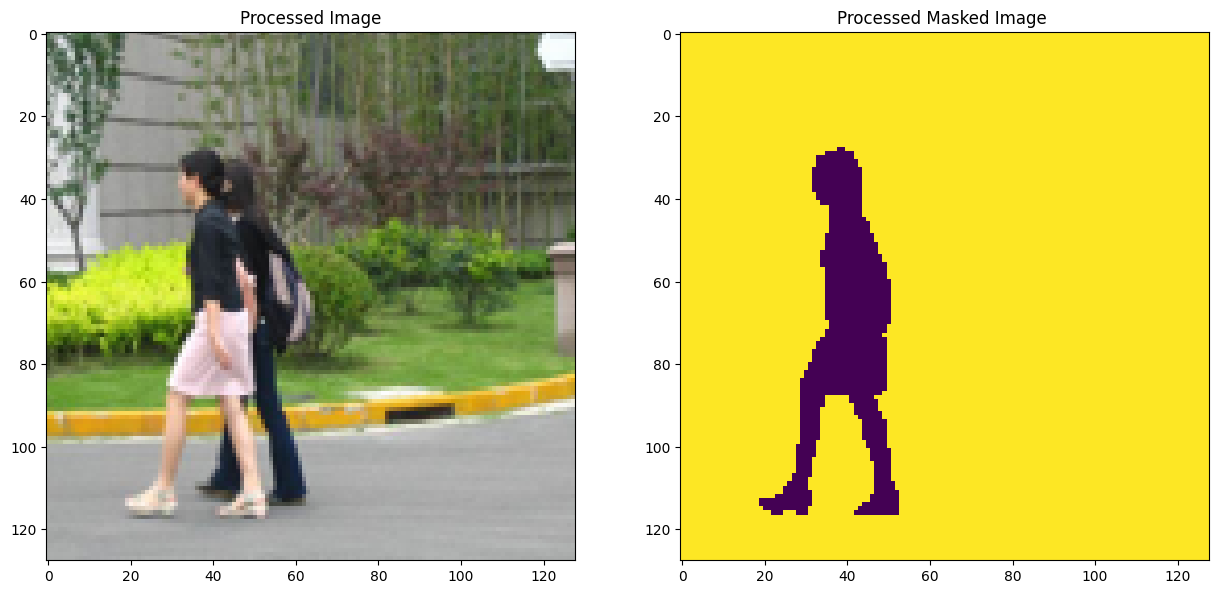

In [10]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 1 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

In [28]:
from torchvision import transforms
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            #mask = self.transform(mask)

        #image = np.expand_dims(image, axis=0)  # Add channel dimension
        #mask = np.expand_dims(mask, axis=0)    # Add channel dimension
        mask = mask.squeeze()  # Remove channel dimension

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# Parameters
batch_size = 4
learning_rate = 0.001
num_epochs = 25

# Transformations (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize image
])

# Create Datasets
train_dataset = CustomDataset(images=X_train, masks=y_train, transform=transform)
valid_dataset = CustomDataset(images=X_valid, masks=y_valid, transform=transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [32]:
import torch.nn.functional as F
# Instantiate the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
# Use binary cross entropy loss since the output is a single channel mask
criterion = nn.BCEWithLogitsLoss() # Changed loss function for single channel output
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # Sigmoid activation to get probabilities
            outputs = torch.sigmoid(outputs) # Added sigmoid activation
            # Ensure masks have the same spatial dimensions as the model output
            masks = F.interpolate(masks.unsqueeze(1), size=outputs.shape[2:], mode='nearest') # Added interpolation
            # Flatten the target mask and output to calculate loss
            loss = criterion(outputs.view(-1), masks.view(-1)) # Modified loss calculation
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks in valid_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                # Sigmoid activation for validation as well
                outputs = torch.sigmoid(outputs) # Added sigmoid activation
                # Ensure masks have the same spatial dimensions for validation
                masks = F.interpolate(masks.unsqueeze(1), size=outputs.shape[2:], mode='nearest') # Added interpolation
                # Flatten for validation loss calculation
                loss = criterion(outputs.view(-1), masks.view(-1)) # Modified loss calculation
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(valid_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')

    return model

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10)

<ipython-input-28-ae445b8e3e44>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


Epoch 1/10, Loss: -186.5102
Validation Loss: -210.6438
Epoch 2/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 3/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 4/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 5/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 6/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 7/10, Loss: -207.2862
Validation Loss: -210.6438
Epoch 8/10, Loss: -207.2862
Validation Loss: -210.6438


KeyboardInterrupt: 